Clustering tests of 3 datasets (breast, skin, ovary)  
Feature matrix is dup and del scores of each cytoband  
Methods:  
 - PCA
 - TSNE
 - PCA50 + TSNE
 - TruncatedSVD, TruncatedSVD_50 + TSNE
 - K-mean
 - AgglomerativeClustering
 - Hierachy dendrogram

In [22]:
import numpy as np
import pandas as pd
import time
from pymongo import MongoClient
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

In [2]:
client = MongoClient()

In [3]:
RS = 1234

In [4]:
samples = []
labels = []
for collection in ['skin','ovary','breast']:
    db = client['Rebased'][collection]
    for sam in db.find({ 'cytobands': { '$exists': True, '$ne': None } }):
        features = []
        for band in sam['cytobands']:
            if band['chro'] not in ['X','Y']:
                features.extend([band['ave_dup'],band['ave_del']])
        samples.append(features)
        labels.append('{}_{}'.format(collection,sam['source']))
        

In [5]:
feat_mat = np.array(samples)

In [6]:
feat_mat.shape

(9636, 1622)

In [28]:
label_3 = [i.split('_')[0] for i in labels]

In [23]:
feat_scaled = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_mat))

In [20]:
label_mat = np.array(labels)

In [53]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(feat_mat)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 0.553225040435791 seconds
Variance explained per principal component: [0.17798351 0.03996287 0.03336266 0.03274641]


In [54]:
pca_df = pd.DataFrame(pca_result, columns = ['pca1','pca2','pca3','pca4'])
pca_df['label'] = label_mat

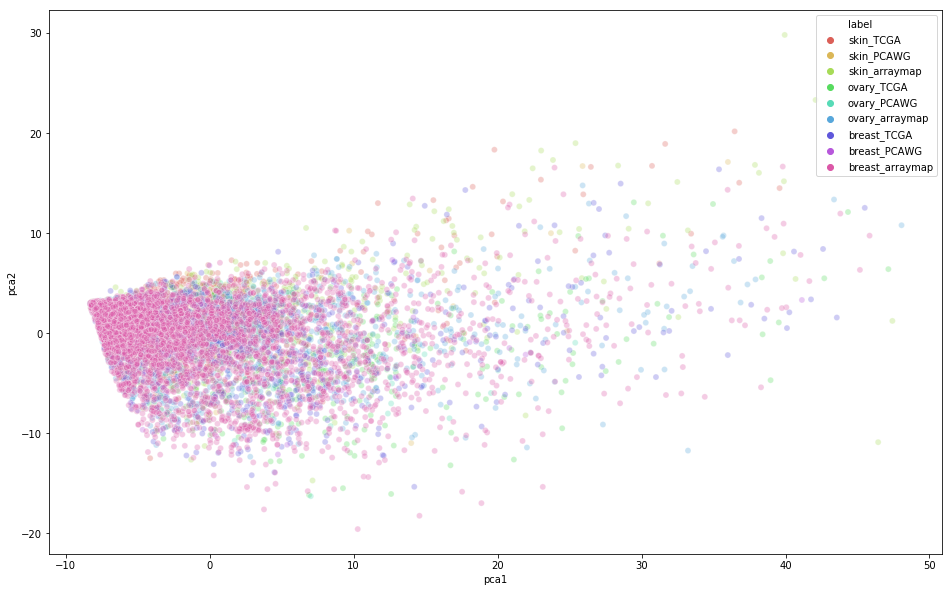

In [55]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=pca_df,
    legend="full",
    alpha=0.3
)

TSNE sometimes fails, don't know why

In [ ]:
time_start = time.time()

fashion_tsne = TSNE(random_state=RS, perplexity=40).fit_transform(feat_mat)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
tsne_df = pd.DataFrame(fashion_tsne, columns = ['tsne1','tsne2'])
tsne_df['label'] = label_mat

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [25]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(feat_scaled)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.627817581942923


In [26]:
time_start = time.time()
pca_tsne = TSNE(random_state=RS, perplexity=40, learning_rate=800).fit_transform(pca_result_50)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 119.16332173347473 seconds


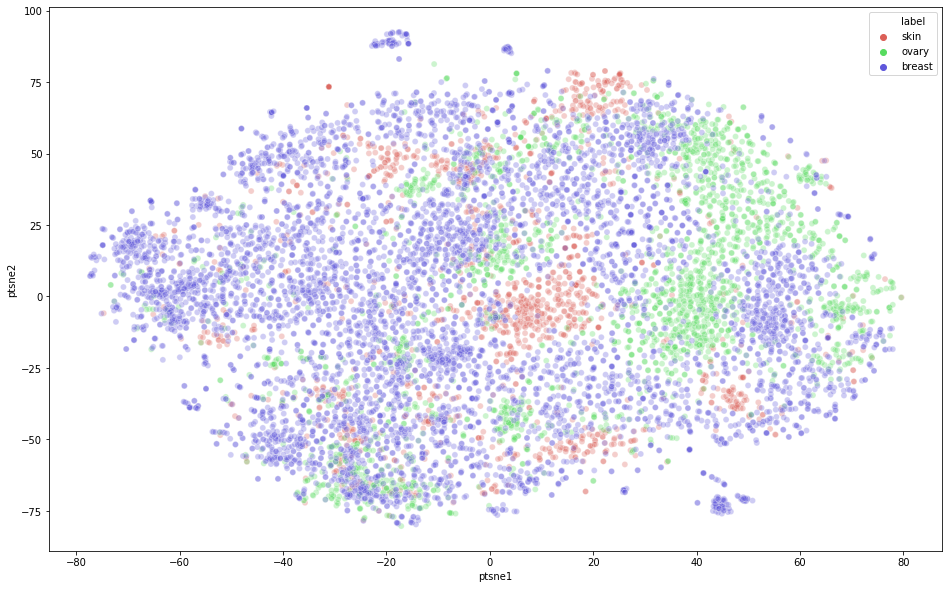

In [29]:
ptsne_df = pd.DataFrame(pca_tsne, columns = ['ptsne1','ptsne2'])
# ptsne_df['label'] = label_mat
ptsne_df['label'] = label_3
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="ptsne1", y="ptsne2",
    hue="label",
#     palette=sns.color_palette("hls", 9),
    palette=sns.color_palette("hls", 3),
    data=ptsne_df,
    legend="full",
    alpha=0.3
)

In [35]:
pca_tsne

array([[-3.38221935e+12,  1.19135902e+13],
       [ 1.01306886e+10,  1.76543688e+12],
       [ 3.33692614e+12,  9.38437142e+12],
       ...,
       [-9.27802649e+11,  2.37989714e+12],
       [-8.89246996e+11,  3.10148452e+12],
       [-8.84178462e+10,  3.77392550e+10]])

In [66]:
time_start = time.time()
svd = TruncatedSVD(n_components=4)
svd_result = svd.fit_transform(feat_mat)

print('TruncatedSVD done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Variance explained per principal component: {}'.format(svd.explained_variance_ratio_))

TruncatedSVD done! Time elapsed: 0.3048257827758789 seconds
Variance explained per principal component: [0.16914964 0.04697208 0.03385799 0.03280321]


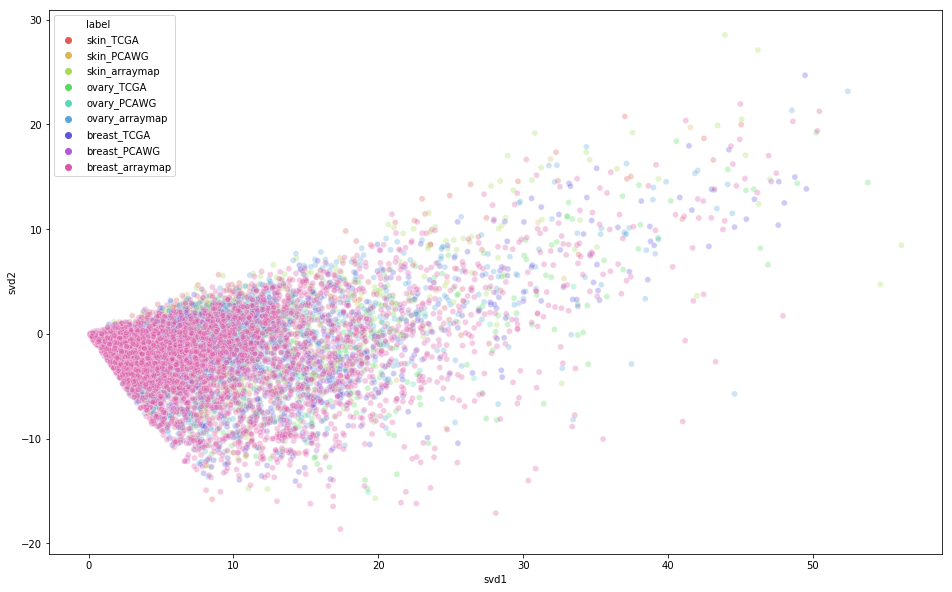

In [67]:
svd_df = pd.DataFrame(svd_result, columns = ['svd1','svd2','svd3','svd4'])
svd_df['label'] = label_mat

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="svd1", y="svd2",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=svd_df,
    legend="full",
    alpha=0.3
)

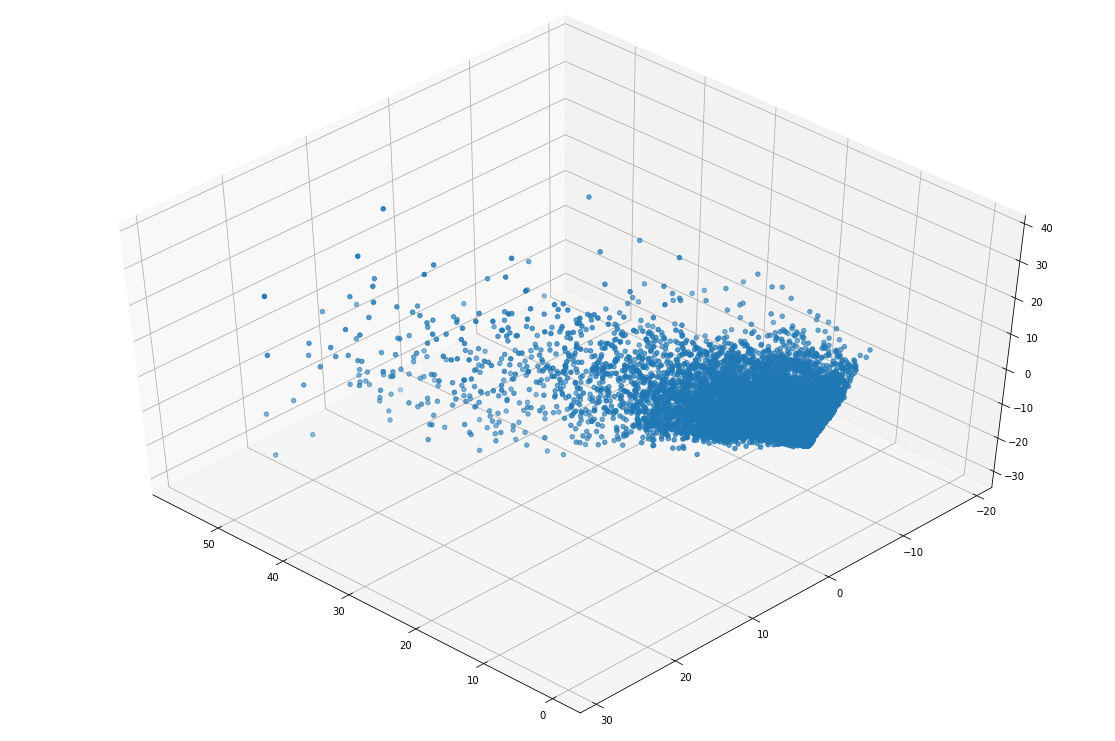

In [77]:
ax = plt.figure(figsize=(16,10))
ax = Axes3D(ax, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(
    xs=svd_df["svd1"], 
    ys=svd_df["svd2"], 
    zs=svd_df["svd3"])

In [78]:
from sklearn.cluster import KMeans

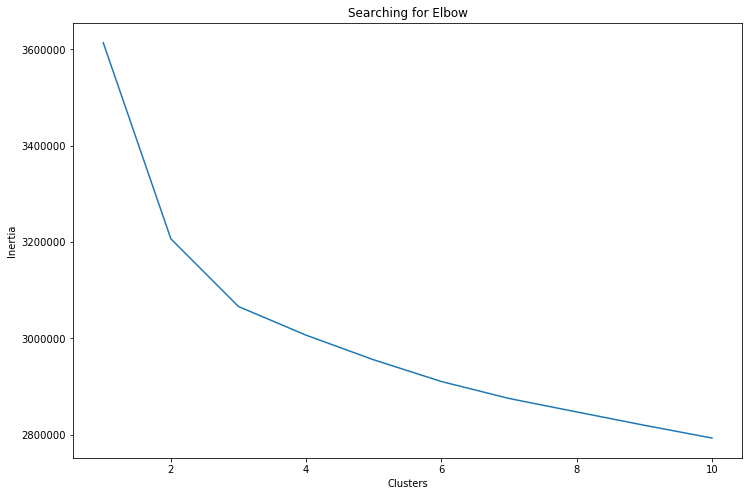

In [79]:
clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(feat_mat)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# # Annotate arrow
# ax.annotate('Possible Elbow Point', xy=(3, 140000), xytext=(3, 50000), xycoords='data',          
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

# ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

In [80]:
km3 = KMeans(n_clusters=3).fit(feat_mat)
km3_df = pd.DataFrame({'km3_label': km3.labels_, 'sample_label':labels})

In [93]:
km2 = KMeans(n_clusters=2).fit(feat_mat)
km2_df = pd.DataFrame({'km2_label': km2.labels_, 'sample_label':labels})

In [ ]:
plt.figure(figsize=(16,10))
ax = sns.catplot(
    x="km3_label", y="sample_label",
    hue="km3_label",
    palette=sns.color_palette("hls", 9),
    data=km3_df,
    legend="full",
    alpha=0.3,
    kind="swarm"
)

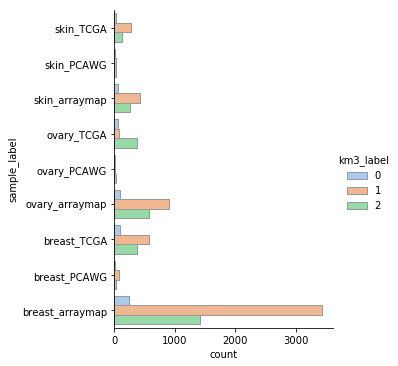

In [106]:
ax = sns.catplot(y="sample_label", hue="km3_label", kind="count",
            palette="pastel", edgecolor=".6",
            data=km3_df)

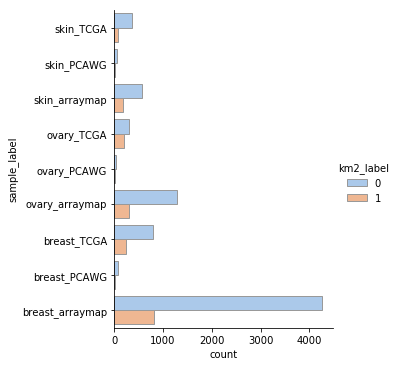

In [94]:
ax = sns.catplot(y="sample_label", hue="km2_label", kind="count",
            palette="pastel", edgecolor=".6",
            data=km2_df)

In [97]:
from sklearn.cluster import AgglomerativeClustering 

In [99]:
clusters = []

for i in range(1, 11):
    agglom = AgglomerativeClustering(n_clusters=i).fit(feat_mat)
    clusters.append(agglom.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')


plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'inertia_'

In [122]:
agglom = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(feat_mat)
agglom_df = pd.DataFrame({'agglom_label': agglom.labels_, 'sample_label':labels})

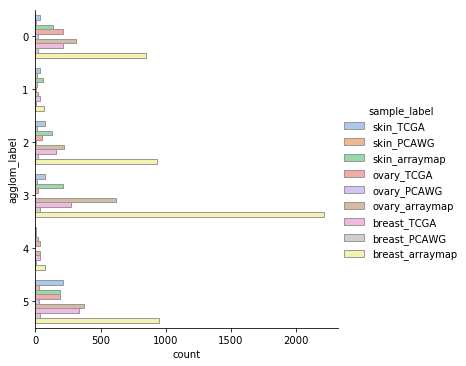

In [123]:
ax = sns.catplot(y="agglom_label", hue="sample_label", kind="count",
            palette="pastel", edgecolor=".6",
            data=agglom_df)
plt.show()

In [118]:
from scipy.cluster import hierarchy

In [120]:
Z = hierarchy.linkage(feat_mat, 'ward')

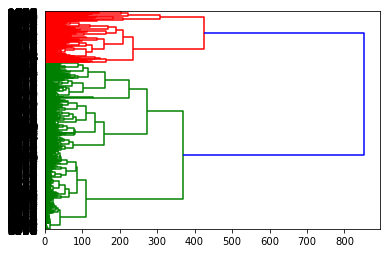

In [121]:
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='right')

Remove na columns

In [18]:
feat_mat.shape

(9636, 1622)

In [17]:
feat_mat[:,~np.all(feat_mat==0, axis=0)].shape

(9636, 1592)

PCA done! Time elapsed: 0.49820899963378906 seconds
Variance explained per principal component: [0.17798351 0.03996287 0.03336266 0.03274641]


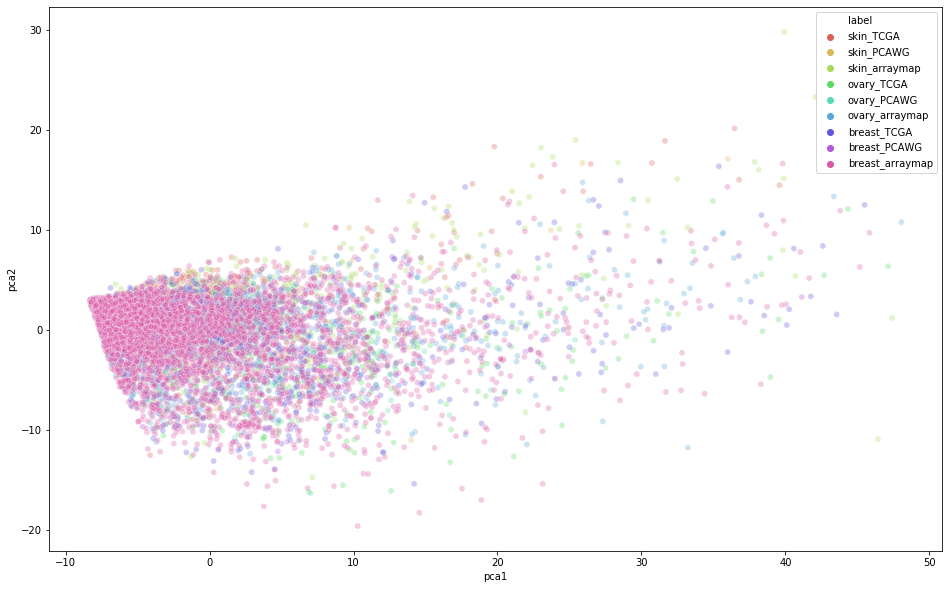

In [21]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result_filter = pca.fit_transform(feat_mat[:,~np.all(feat_mat==0, axis=0)])

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

pca_filter_df = pd.DataFrame(pca_result_filter, columns = ['pca1','pca2','pca3','pca4'])
pca_filter_df['label'] = label_mat

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=pca_filter_df,
    legend="full",
    alpha=0.3
)